### ExamineAgeMenopause
##### E Flynn
##### 7/2/2018

The goal of this notebook is to bin the data by age, and then also into pre-post menopause, and examine these differences. 

Then, we will set up the phenotype definition for females and menopause:
* Pre-menopause: stated they have not reached menopause -AND- are less than 70 years old
* Post-menopause: >2 years post menopause -AND- had menopause after age 40

Excluded others

In [1]:
require('tidyverse')

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.1     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
target_dir <- '/oak/stanford/groups/mrivas/ukbb/24983/'
covar_file <- 'phe_qc/ukb24983_GWAS_covar.phe'


covar_data <- read.table(sprintf("%s/%s", target_dir, covar_file), header=TRUE, stringsAsFactors=FALSE)

In [3]:
menopause_bin <- read.table("../phefiles/ss/BIN_FC1002724.phe")
menopause_age <- read.table("../phefiles/ss/INI3581.phe")

In [4]:
colnames(menopause_bin) <- c("ID", "ID2", "val")
colnames(menopause_age) <- c("ID", "ID2", "val")

head(menopause_bin)
    # 1 = no, 2 = yes, -9 = missing/male/prefer not to answer
    # inferring recoding from counts, should double check
table(menopause_bin$val)
menopause_bin_present <- filter(menopause_bin, val !=-9)
head(menopause_age)
menopause_age_present <- filter(menopause_age, val !=-9)


head(select(menopause_bin_present, -ID2))

ID,ID2,val
6016674,6016674,-9
3717852,3717852,2
1028557,1028557,-9
6005719,6005719,2
1409072,1409072,1
1059353,1059353,1



    -9      1      2 
272068  62462 168092 

ID,ID2,val
6016674,6016674,-9
3717852,3717852,45
1028557,1028557,-9
6005719,6005719,52
1409072,1409072,-9
1059353,1059353,-9


ID,val
3717852,2
6005719,2
1409072,1
1059353,1
4600492,1
4557372,2


In [5]:
meno_combined <- full_join(select(menopause_bin_present, -ID2), select(menopause_age_present, -ID2),by="ID", suffix=c(".bin", ".age"))
colnames(meno_combined) <- c("IID", "meno", "meno.age") # rename the menoapuse columns
head(covar_data[,1:8])
covar_data_f <- filter(covar_data, sex==0)
head(meno_combined)
combined_age_dat <- left_join(meno_combined,select(covar_data_f, c(IID, age, sex)), by="IID" ) # combine the data frames

combined_age_dat <- mutate(combined_age_dat, years.post=ifelse(meno.age<0, NA, age - meno.age)) # compute the years since menopause
combined_age_dat <- mutate(combined_age_dat, meno=(meno!=1)) # convert the menopause coding to TRUE and FALSE

FID,IID,age,sex,Array,PC1,PC2,PC3
2502845,2502845,50,1,1,-12.1725,5.39163,-1.281030
2314965,2314965,55,0,1,-13.0245,6.41514,-0.183365
1142584,1142584,60,0,1,-11.4712,3.48383,-1.154580
3665122,3665122,74,0,1,-12.1327,4.02976,-0.988080
4377492,4377492,65,0,1,-12.2171,3.50821,-1.625990
2652670,2652670,58,1,1,-11.5847,5.41131,0.785815


IID,meno,meno.age
3717852,2,45
6005719,2,52
1409072,1,NA
1059353,1,NA
4600492,1,NA
4557372,2,52


In [6]:
table(meno_combined$meno)
table(combined_age_dat$meno)


     1      2 
 62462 168092 


 FALSE   TRUE 
 62462 168092 

In [7]:
# make sure there are no males!
table(combined_age_dat$sex)


     0 
223433 

In [8]:
write.table(combined_age_dat, file="../data/menopause_age_data.txt", row.names=FALSE, quote=FALSE )

IID,meno,meno.age,age,sex,years.post
3717852,TRUE,45,64,0,19
6005719,TRUE,52,78,0,26
1409072,FALSE,NA,51,0,NA
1059353,FALSE,NA,53,0,NA
4600492,FALSE,NA,55,0,NA
4557372,TRUE,52,71,0,19


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


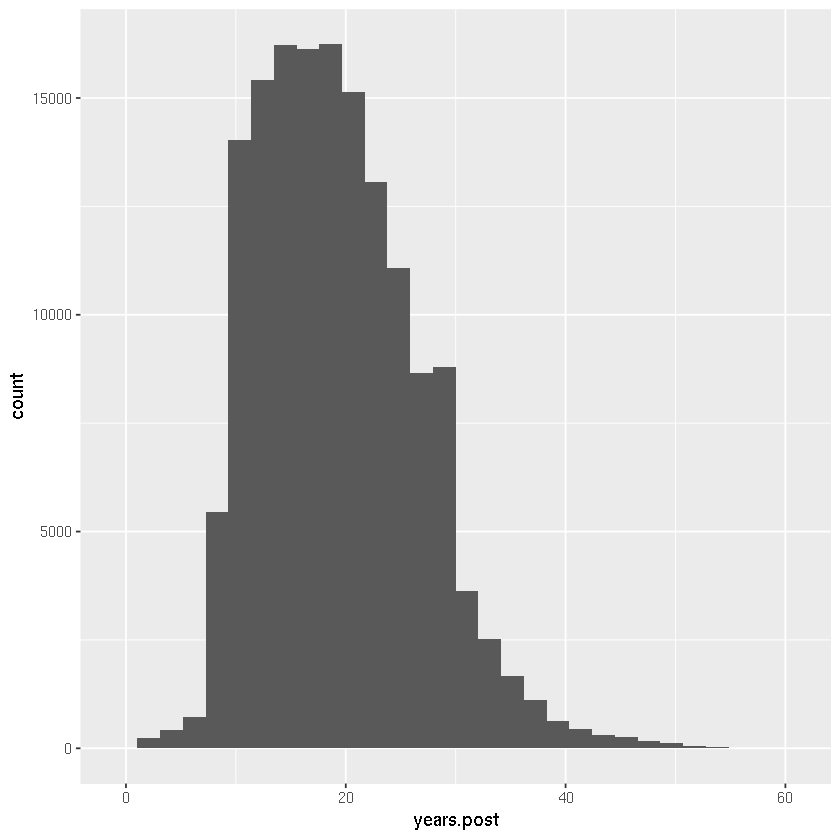

In [9]:
# separate people into post-menopause (>2years), peri-menopause (0-2years), pre-menopause
# -- reason to do this
# how many fall in each category?
head(combined_age_dat)
ggplot(data=combined_age_dat[!is.na(combined_age_dat$years.post),], aes(years.post)) +geom_histogram()

In [10]:

nrow(filter(combined_age_dat, years.post < 2 & !is.na(years.post))) # 15 

# premature menopause - occuring in a woman younger than 40 years
nrow(filter(combined_age_dat, meno.age < 40 & !is.na(years.post)))
nrow(filter(combined_age_dat, meno.age < 30 & !is.na(years.post)))

nrow(filter(combined_age_dat, meno.age >= 40 & years.post >=2 & !is.na(years.post))) # 145,812


[1] 15

[1] 6746

[1] 1201

[1] 145796

In [11]:
nrow(filter(combined_age_dat, !meno & age > 70))
nrow(filter(combined_age_dat, !meno & age <= 70))

# there are a lot of people over 65 who have not had menopause... this is surprising to me

[1] 579

[1] 59895

In [12]:
nrow(filter(combined_age_dat, !meno & is.na(age))) # some are missing age data

[1] 1988

In [13]:
# phenotype-label
# 1 = menopause, 0 = pre-menopause, NA = QC removed
combined_age_dat2 <- mutate(combined_age_dat, 
                            phe.label=ifelse(meno.age >= 40 & years.post >=2 & !is.na(years.post), 1,
                                             ifelse(!meno & age <= 70, 0, NA)))

table(combined_age_dat2$phe.label)


     0      1 
 59895 145796 

[1] 62462

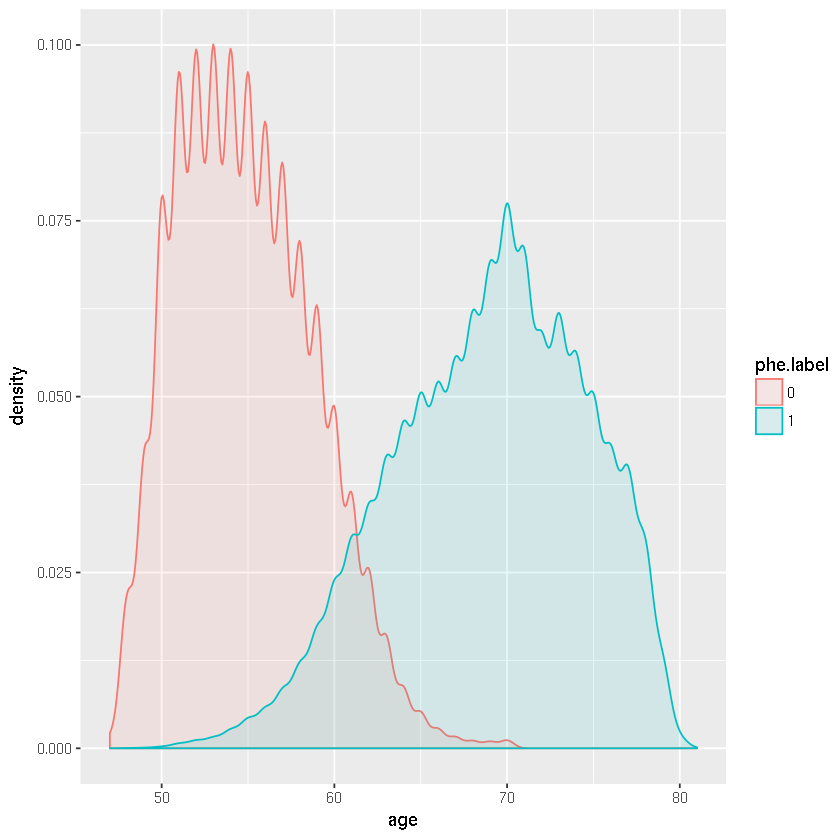

In [14]:
nrow(filter(combined_age_dat, !meno)) # 62,462

combined_age_dat3 <- combined_age_dat2[!is.na(combined_age_dat2$phe.label),]
combined_age_dat3$phe.label <- as.factor(combined_age_dat3$phe.label)
ggplot(data=combined_age_dat3, aes(age, colour=phe.label, fill=phe.label)) +geom_density(alpha=0.1)

# this really divides the group by age <-- although some of this is by definition


In [15]:
# write out the labels as phe files
pre_meno <- filter(combined_age_dat3, phe.label == 0 )
#write.table(select(pre_meno, IID), file="../phefiles/pre_meno.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)
post_meno <- filter(combined_age_dat3, phe.label == 1 )
#write.table(select(post_meno, IID), file="../phefiles/post_meno.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)

# Qs to ask:
# - does age affect this?


In [22]:
# how do I have more females than I thought?
# - are we removing the appropriate samples?
onesex.tab <- read.table("../phefiles/old_sex_labels/onesex.keep") # 156k
nrow(onesex.tab)

zerosex.tab <- read.table("../phefiles/old_sex_labels/zerosex.keep") # 181k
nrow(zerosex.tab)

# - yet somehow I have 168+62 :/ 

# oh whoops - forgot to remove data 
removal_file_one <- '/oak/stanford/groups/mrivas/ukbb/24983/sqc/ukb24983_remove.phe'
removal_file_two <- '/oak/stanford/groups/mrivas/ukbb/24983/sqc/w2498_20170726.phe'
remove1 <- read.table(removal_file_one, header=FALSE)
remove2 <- read.table(removal_file_two, header=FALSE) # this file is messy b/c of meta characters - only has three people in it tho
ids.to.remove <- c(remove1[,1], unique(remove2[,1]))


[1] 156135

[1] 181064

In [30]:
head(ids.to.remove)
pre_meno2 <- pre_meno[!(pre_meno$IID %in% ids.to.remove),] # 38,945
(num.pre <- nrow(pre_meno2))
post_meno2 <- post_meno[!(post_meno$IID %in% ids.to.remove),] # 101,586
(num.post <- nrow(post_meno2))

# ok this is more reasonable

# re-write the files
write.table(select(pre_meno2, IID), file="../phefiles/pre_meno.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)
write.table(select(post_meno2, IID), file="../phefiles/post_meno.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)


[1] 2652670 2850227 3946352 3073546 2063443 4144793

[1] 38945

[1] 101586

In [35]:
# down-sample
# - does the label imbalance affect things?

# what if we downsample post_meno to 38k? (is this too small)

# also downsample males

set.seed(724)
keep_rows_post <- sample(1:num.post, num.pre, replace=FALSE)
onesex.tab <- read.table("../phefiles/old_sex_labels/onesex.keep") # 156k
colnames(onesex.tab) <- "IID"
num.m <- nrow(onesex.tab)
keep_rows_male <- sample(1:num.m, num.pre, replace=FALSE)
post_meno_down <- post_meno2[keep_rows_post,]
onesex_down <- onesex.tab[keep_rows_male,]

# write these out
write.table(select(pre_meno2, IID), file="../pr")
write.table(select(post_meno_down, IID), file="../phefiles/post_meno_d.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)
#write.table(select(onesex_down, IID), file="../phefiles/onesex_d.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)
write.table(onesex_down, file="../phefiles/onesex_d.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)

In [48]:
# age-divide the data
# at what cut-point? we could do over + under 65

head(covar_data[,1:5])
covar_data_keep <- covar_data[!(covar_data$IID %in% ids.to.remove),]
covar_data_keep %>% group_by(sex) %>% summarize(median(age)) # mean age is ~65

table(covar_data_keep[covar_data_keep$age < 50,]$sex) # only 2k in each --> POOR CHOICE

FID,IID,age,sex,Array
2502845,2502845,50,1,1
2314965,2314965,55,0,1
1142584,1142584,60,0,1
3665122,3665122,74,0,1
4377492,4377492,65,0,1
2652670,2652670,58,1,1


sex,median(age)
0,67
1,68



   0    1 
2207 1990 

In [49]:
over65.f <- covar_data_keep$IID[covar_data_keep$age > 65 & covar_data_keep$sex == 0]
over65.m <- covar_data_keep$IID[covar_data_keep$age > 65 & covar_data_keep$sex == 1]
under65.f <- covar_data_keep$IID[covar_data_keep$age <= 65 & covar_data_keep$sex == 0]
under65.m <- covar_data_keep$IID[covar_data_keep$age <= 65 & covar_data_keep$sex == 1]

In [53]:
length(over65.f) # 99571
length(over65.m) # 90319
length(under65.f) # 81496
length(under65.m) # 65820 -- huh this is less!

# for now - just run with all
# next time --> we will try downsampling

write.table(over65.f, file="../phefiles/over65_f.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)
write.table(over65.m, file="../phefiles/over65_m.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)
write.table(under65.f, file="../phefiles/under65_f.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)
write.table(under65.m, file="../phefiles/under65_m.keep", quote=FALSE, row.names=FALSE, col.names=FALSE)

[1] 99571

[1] 90319

[1] 81496

[1] 65820